Style GAN

In [15]:
#import stuff
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Parameters

In [2]:
batch_size = 32
depth = 32

Load and process the data

In [17]:
#load raw data
raw_ds = tf.keras.preprocessing.image_dataset_from_directory('D:/Datasets/AKOA_Analysis', labels=None, color_mode='grayscale', batch_size=batch_size)
print(raw_ds)

#check range of values in raw data
image_batch = next(iter(raw_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

#normalise the data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
norm_ds = raw_ds.map(lambda img: (normalization_layer(img)))

#check range of values in raw data
image_batch = next(iter(norm_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


Found 18680 files belonging to 1 classes.
<BatchDataset shapes: (None, 256, 256, 1), types: tf.float32>
0.0 255.0
-1.0 1.0


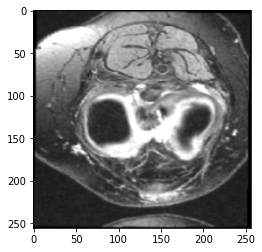

In [22]:
#visualise raw data
for images in raw_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"), cmap='gray')
    plt.show()

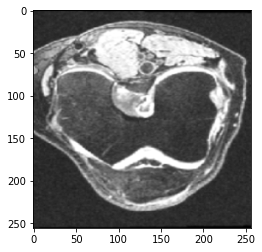

In [20]:
#visualise norm data
for images in norm_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"), cmap='gray')
    plt.show()

Networks

In [ ]:
#define generator

In [ ]:
#create generator

In [ ]:
#define discriminator

In [ ]:
#create discriminator

Training

In [ ]:
#define training step

In [ ]:
#define training loop

In [ ]:
#run training loop

Visualise outcome

In [ ]:
#losses and inference